In [ ]:
# https://ceb.nlm.nih.gov/repositories/malaria-datasets/ 

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.image import imread
%matplotlib inline

In [15]:
data_dir = 'C:/Users/antho/Desktop/VSC/My_Projects/SL_CNN/data/cell_images'

In [16]:
test_path = data_dir+'/test'
train_path = data_dir+'/train'

In [17]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [18]:
os.listdir(train_path)

['parasitized', 'uninfected']

In [23]:
os.listdir(train_path+'\\parasitized')[69]

'C101P62ThinF_IMG_20150918_151006_cell_81.png'

In [25]:
para_cell = train_path+'\\parasitized'+'\\C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [26]:
para_img= imread(para_cell)

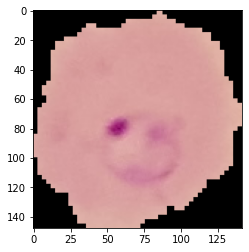

In [27]:
plt.imshow(para_img)

In [28]:
para_img.shape

(148, 142, 3)

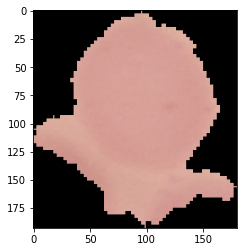

In [31]:
uninfected_cell_path = train_path+'/uninfected/'+os.listdir(train_path+'/uninfected')[15]
uninfected_cell = imread(uninfected_cell_path)
plt.imshow(uninfected_cell)

In [32]:
len(os.listdir(train_path+'/parasitized'))

12480

In [33]:
len(os.listdir(train_path+'/uninfected'))

12480

In [34]:
uninfected_cell.shape

(193, 181, 3)

In [35]:
para_img.shape

(148, 142, 3)

In [36]:
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'/uninfected'):
    
    img = imread(test_path+'/uninfected'+'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

c:\Users\antho\anaconda3\envs\mytfenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


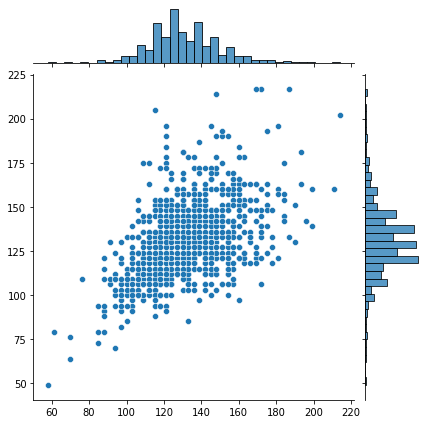

In [37]:
sns.jointplot(dim1,dim2)

In [38]:
np.mean(dim1)

130.92538461538462

In [39]:
np.mean(dim2)

130.75

In [40]:
image_shape = (130,130,3)

Model Prep

In [41]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [43]:
# help(ImageDataGenerator)

In [44]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allow horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

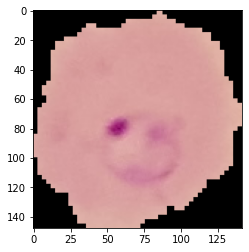

In [45]:
plt.imshow(para_img)

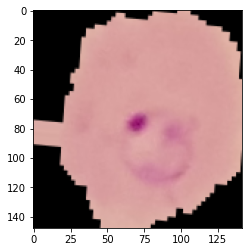

In [57]:
plt.imshow(image_gen.random_transform(para_img))

In [59]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [60]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


Create the model

In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping


In [63]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())


model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']) # 2 classes: uninfected vs parasitic

In [66]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [67]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [68]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=16,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [70]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=16,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


In [71]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [72]:
import warnings
warnings.filterwarnings('ignore')

In [73]:
results = model.fit_generator(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                              callbacks=[early_stop])

Epoch 1/20
1560/1560 [==============================] - 163s 102ms/step - loss: 0.3026 - accuracy: 0.8785 - val_loss: 0.1948 - val_accuracy: 0.9296
Epoch 2/20
1560/1560 [==============================] - 89s 57ms/step - loss: 0.1800 - accuracy: 0.9453 - val_loss: 0.1794 - val_accuracy: 0.9465
Epoch 3/20
1560/1560 [==============================] - 88s 56ms/step - loss: 0.1660 - accuracy: 0.9478 - val_loss: 0.1560 - val_accuracy: 0.9477
Epoch 4/20
1560/1560 [==============================] - 88s 56ms/step - loss: 0.1671 - accuracy: 0.9477 - val_loss: 0.1569 - val_accuracy: 0.9477
Epoch 5/20
1560/1560 [==============================] - 90s 58ms/step - loss: 0.1589 - accuracy: 0.9495 - val_loss: 0.1528 - val_accuracy: 0.9504
Epoch 6/20
1560/1560 [==============================] - 90s 58ms/step - loss: 0.1544 - accuracy: 0.9512 - val_loss: 0.1554 - val_accuracy: 0.9458
Epoch 7/20
1560/1560 [==============================] - 88s 56ms/step - loss: 0.1564 - accuracy: 0.9504 - val_loss: 0.1466

Evaluate the model

In [84]:
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report,confusion_matrix

In [75]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

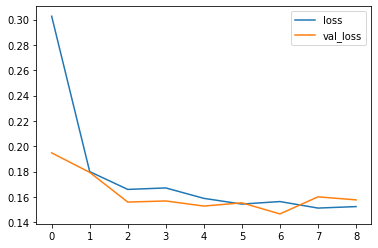

In [76]:
losses[['loss','val_loss']].plot()

In [77]:
model.metrics_names

['loss', 'accuracy']

In [78]:
model.evaluate_generator(test_image_gen)

[0.1506318598985672, 0.9484615325927734]

In [80]:
pred_probabilities = model.predict_generator(test_image_gen)

In [81]:
pred_probabilities

array([[0.00218044],
       [0.00167041],
       [0.00795534],
       ...,
       [0.93059915],
       [0.9206598 ],
       [0.915976  ]], dtype=float32)

In [82]:
test_image_gen.classes

array([0, 0, 0, ..., 1, 1, 1])

In [83]:
predictions = pred_probabilities > 0.5

In [85]:
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1300
           1       0.94      0.96      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



In [86]:
confusion_matrix(test_image_gen.classes,predictions)

array([[1215,   85],
       [  49, 1251]], dtype=int64)

In [87]:
para_cell

'C:/Users/antho/Desktop/VSC/My_Projects/SL_CNN/data/cell_images/train\\parasitized\\C100P61ThinF_IMG_20150918_144104_cell_162.png'

In [88]:
my_image = image.load_img(para_cell,target_size=image_shape)

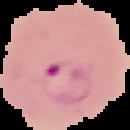

In [89]:
my_image

In [90]:
type(my_image)

PIL.Image.Image

In [91]:
my_image = image.img_to_array(my_image)

In [92]:
type(my_image)

numpy.ndarray

In [93]:
my_image.shape

(130, 130, 3)

In [94]:
my_image = np.expand_dims(my_image, axis=0)

In [95]:
my_image.shape

(1, 130, 130, 3)

In [96]:
model.predict(my_image)

1/1 [==============================] - 0s 216ms/step


array([[0.]], dtype=float32)

In [97]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [98]:
test_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [ ]:
from tensorflow.keras.models import load_model
model.save('malaria_detector.h5')